## OVERVIEW

Company Zen sells Apple and Google products and they seek to figure out how their products are doing in the market. Twitter is the main platform where the users rate and tweet their sentiments on their products. Zen seeks to find out the analysis of the feedbacks to know how the products are performing and to also inform on their relationship with Google and Apple.

## PROBLEM STATEMENT

Its important for a company to know how they products are being received in the market and what products have a positive or negative feedback from the users. This information is used to make informed decisions on their products and provide recommendations on what to do so as to remain competitive. Therefore this project seeks to analyse the tweets sentiments of Company zens Apple and Google products and also build an NLP model that can rate tweets sentiments and provide reccommendation for decision making.

## OBJECTIVES

1. Analyse the sentiments into positive, negatie and neutral
2. Identify the products that have positive and negative feedback
3. Develop an NLP model that can rate a tweet feedback to inform the ompany on performance

## DATA UNDERSTANDING

The data used in this project was sourced from data.world. It contains tweet reviews for brands and products and it will be used to develop our NLP model that can rate a sentiment of a tweet based on its content whether positive, negative or neutral.

In [36]:
#Import relevant libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
import re
nltk.download('punkt')
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.sparse.csr import csr_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
#load the data
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
df.shape

(9093, 3)

In [6]:
df.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [7]:
df.rename(columns ={
    'tweet_text' : 'Text' ,
    'emotion_in_tweet_is_directed_at' : 'Product' ,
    'is_there_an_emotion_directed_at_a_brand_or_product' : 'Emotion'
}, inplace=True )

In [8]:
df.describe(include='all')

,Text,Product,Emotion
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


## DATA PREPARATION

This step involves examining the dataframe for any anomalies. It involves analysizing the data to identify any missing values, duplicated values etc

In [9]:
# chek for duplicates 

num_duplicates = df.duplicated().sum()
print(f"Number of duplicated rows: {num_duplicates}")

# drop the duplicated rows

df = df.drop_duplicates()

Number of duplicated rows: 22


In [10]:
# check for missing values

df.isnull().sum()

Text          1
Product    5789
Emotion       0
dtype: int64

In [11]:
# drop missing values in 'Text' column
df = df.dropna(subset=['Text'])

# fill missing values in 'Product' column as tey are too many to drop

df['Product'].fillna('Unknown Product',inplace = True)

# check that the missing values have been handled

df.isnull().sum()

Text       0
Product    0
Emotion    0
dtype: int64

In [12]:
emotion_summary = df['Emotion'].value_counts()
emotion_perc = df['Emotion'].value_counts(normalize=True)
print(emotion_summary)
print('----------------------------------')
print('Percentages')
print(emotion_perc*100)

Emotion
No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: count, dtype: int64
----------------------------------
Percentages
Emotion
No emotion toward brand or product    59.261301
Positive emotion                      32.745314
Negative emotion                       6.273429
I can't tell                           1.719956
Name: proportion, dtype: float64


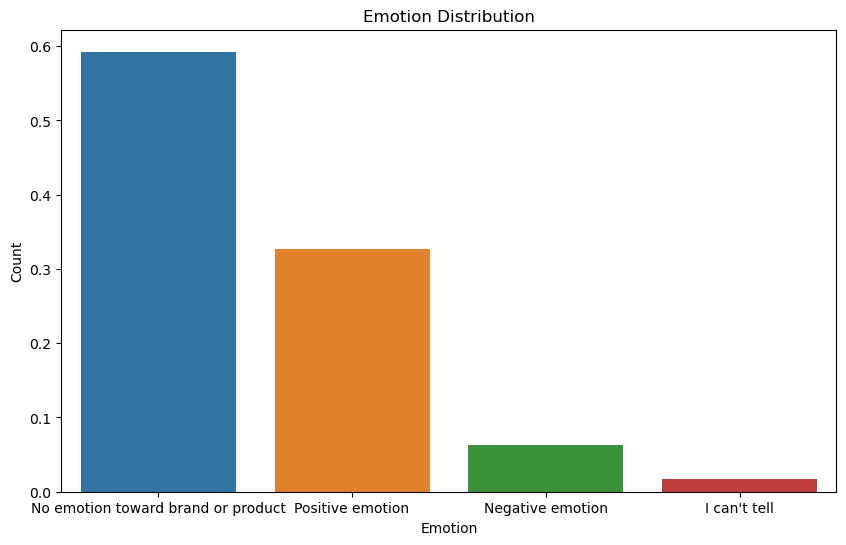

In [13]:
# create a bar plot

plt.figure(figsize=(10,6))
sns.barplot(x=emotion_perc.index, y=emotion_perc.values)

plt.title('Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')

plt.show()

In [14]:
# drop the 'i cant tell' class label
df = df[(df['Emotion'] != "I can't tell")]

# rename the 'no emotion toward brand or porduct' as Neutral
df['Emotion']. replace ('No emotion towarsbrand or product', 'Neutral')

# Encoding the class label
label_encoder = {'Negative emotion':'negative',
                  'Positive emotion':'positive',
                  'No emotion toward brand or product':'neutral'}

df['Emotion'] = df['Emotion'].map(label_encoder)

# check to see if it has changed
emotion_count = df['Emotion'].value_counts()
emotion_count

Emotion
neutral     5375
positive    2970
negative     569
Name: count, dtype: int64

Product
Unknown Product                    5641
iPad                                941
Apple                               657
iPad or iPhone App                  469
Google                              427
iPhone                              295
Other Google product or service     292
Android App                          80
Android                              77
Other Apple product or service       35
Name: count, dtype: int64


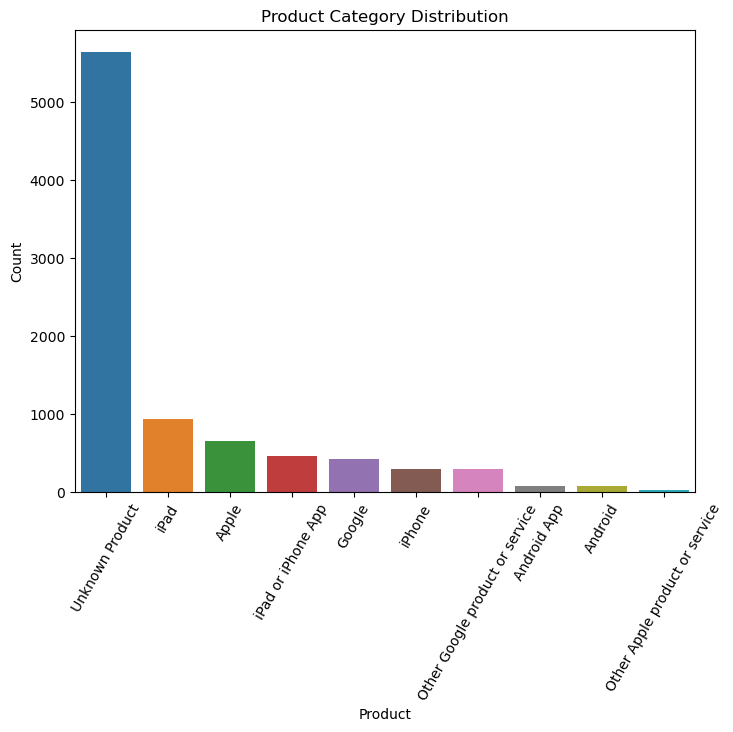

In [15]:
product_count = df['Product'].value_counts()
print(product_count)

# create a bar plot
plt.figure(figsize=(8,6))
sns.barplot(x=product_count.index, y=product_count.values)

plt.xlabel('Product')
plt.ylabel('Count')
plt.title('Product Category Distribution')
plt.xticks(rotation=60)

plt.show()

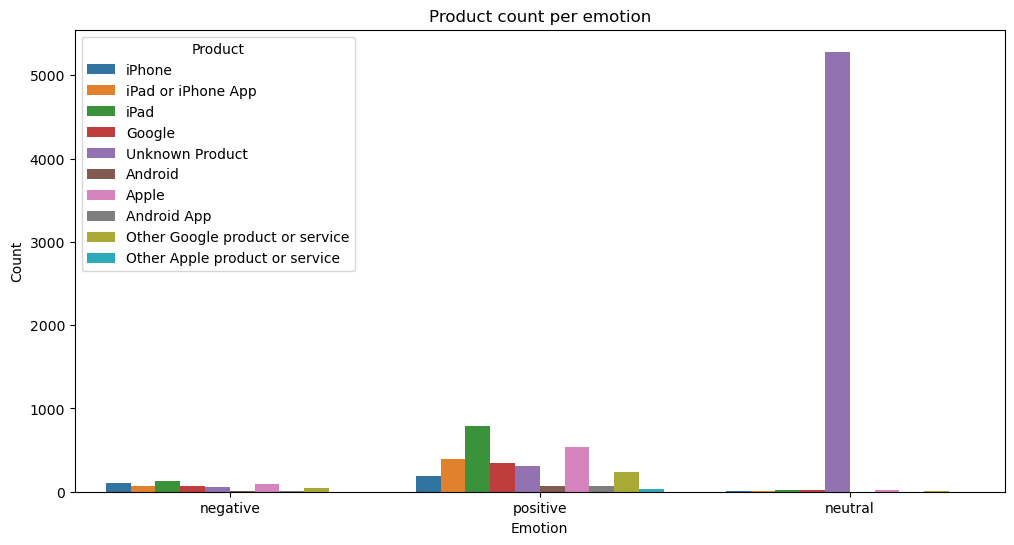

In [16]:
# plotting by emotion
plt.figure(figsize=(12,6))
ax = sns.countplot(data=df, x='Emotion', hue='Product')
plt.title('Product count per emotion')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

According to our graph, there are more unknown products from the neutral column. To solve this, we chek the contents of the tweets in the unknown products and using keywords we assign them to the product column. Those that will not contain the keywords, we will drop them.

In [18]:
# Listing all the tweets in the unknown class that contain any word related to apple or google products
apple_keywords = [
    "apple", "iPhone", "iPad", "MacBook", "Apple Watch", 
    "AirPods", "Apple TV", "Apple Music", "iCloud", 
    "AppleCare", "iPod", "Apple Pay", "ios", "iPhone app"
]
google_keywords = ["Pixel", "Google Home", "Google Assistant", "Chromebook", 
                   "Android App", "Android", "Google Search", "Google Maps", 
                   "Google Drive", "Google Docs", "Google Sheets", "Google Slides", 
                   "Google Photos", "Google Play", "Google Assistant", "Google Home", "Pixel (Phone)", 
    "Pixelbook", "Chromebook", "Nest (Products)", "Google Chrome", "Android", "Gmail",
    "Google AdWords", "Google Analytics", "YouTube", "Google Cloud", "Google Duo", "Google Meet", "Google Fi"]

all_keywords = apple_keywords + google_keywords

# Function to extract product keywords from a tweet
def extract_product_keyword(text):
    for keyword in all_keywords:
        if re.search(r'\b' + re.escape(keyword) + r'\b', text, re.IGNORECASE):
            return keyword
    return None
# Replace 'Unknown Product' with detected product keywords
df['Product'] = df.apply(lambda row: extract_product_keyword(row['Text']) if row['Product'] == "Unknown Product" else row['Product'], axis=1)

# Running product count again
product_counts = df['Product'].value_counts()
product_counts

Product
iPad                               1890
apple                              1176
iPhone                             1160
Apple                               657
iPad or iPhone App                  469
Google                              427
Other Google product or service     292
Android                             265
Android App                         101
Google Maps                          76
Other Apple product or service       35
ios                                  19
Google Analytics                     16
Google Docs                          10
YouTube                               5
Google Search                         5
Google Chrome                         3
Google AdWords                        2
Gmail                                 2
Name: count, dtype: int64

In [19]:
# check to see if there is any remaining unknown products
unknown_products = df[df['Product'] == 'Unknown Product']
print(unknown_products.value_counts().sum())

# if any remaining, drop them
df = df[df['Product'].notnull()]

# Value count grouped by emotion
emotion_count = df.groupby(['Product', 'Emotion']).size().reset_index(name='Count')
emotion_count

0


,Product,Emotion,Count
0,Android,negative,10
1,Android,neutral,176
2,Android,positive,79
3,Android App,negative,8
4,Android App,neutral,21
5,Android App,positive,72
6,Apple,negative,95
7,Apple,neutral,21
8,Apple,positive,541
9,Gmail,neutral,2


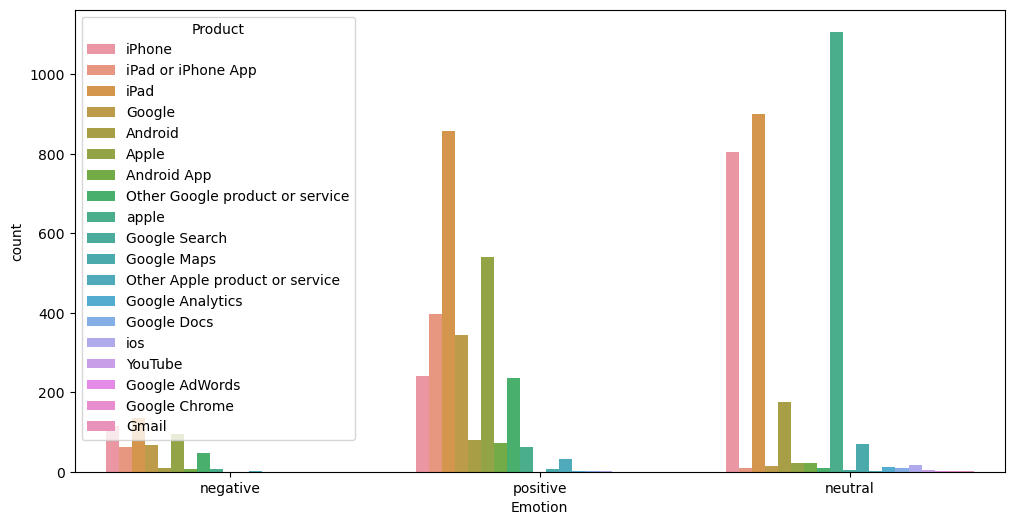

In [22]:
# visualize it
plt.figure(figsize=(12,6))
ax = sns.countplot(data=df, x='Emotion', hue='Product')

Having grouped the products per emotion, lets group them per brand

In [23]:
#creating a copy of the dataframe
df_copy = df.copy()

In [25]:
# Sample list of entries
entries = [
    "Android", "Android", "Android", "Android App", "Android App", "Android App",
    "Apple", "Apple", "Apple", "Gmail", "Google", "Google", "Google AdWords",
    "Google Analytics", "Google Analytics", "Google Chrome", "Google Docs",
    "Google Docs", "Google Maps", "Google Maps", "Google Search",
    "Other Apple product or service", "Other Apple product or service",
    "Other Apple product or service", "Other Google product or service",
    "Other Google product or service", "Other Google product or service",
    "YouTube", "apple", "apple", "apple", "iPad", "iPad", "iPad",
    "iPad or iPhone App", "iPad or iPhone App", "iPad or iPhone App",
    "iPhone", "iPhone", "iPhone", "ios", "ios"
]
# define the mapping
def categorize(entry):
    entry_lower = entry.lower()
    if any(keyword.lower() in entry_lower for keyword in apple_keywords):
        return "Apple"
    elif any (keyword.lower() in entry_lower for keyword in google_keywords):
        return "Google"
    else:
        return "Other"

#create key-value pair list
key_value_pairs = {entry:categorize(entry) for entry in entries}

print(key_value_pairs)

{'Android': 'Google', 'Android App': 'Google', 'Apple': 'Apple', 'Gmail': 'Google', 'Google': 'Other', 'Google AdWords': 'Google', 'Google Analytics': 'Google', 'Google Chrome': 'Google', 'Google Docs': 'Google', 'Google Maps': 'Google', 'Google Search': 'Google', 'Other Apple product or service': 'Apple', 'Other Google product or service': 'Other', 'YouTube': 'Google', 'apple': 'Apple', 'iPad': 'Apple', 'iPad or iPhone App': 'Apple', 'iPhone': 'Apple', 'ios': 'Apple'}


In [29]:
# Map products to condensed categories
df['Product'] = df['Product'].replace(key_value_pairs)

# Output the condensed products
print(df['Product'].value_counts())

Product
Apple    5406
Other    1204
Name: count, dtype: int64


In [33]:
# plottong the count for each brand
fig =  plt.figure(figsize=(12,6))
sns.countplot(x='Product', data=df, hue='Product', palette={'Apple':'r', 'Google':'b', 'Unknown':'g'}, alpha=0.7)
plt.title('Tweet Counts per Brand', size=20)
plt.xlabel('Brands', size=15)
plt.ylabel('Count', size=15)
plt.show()

KeyError: 'iPhone'

<Figure size 1200x600 with 0 Axes>

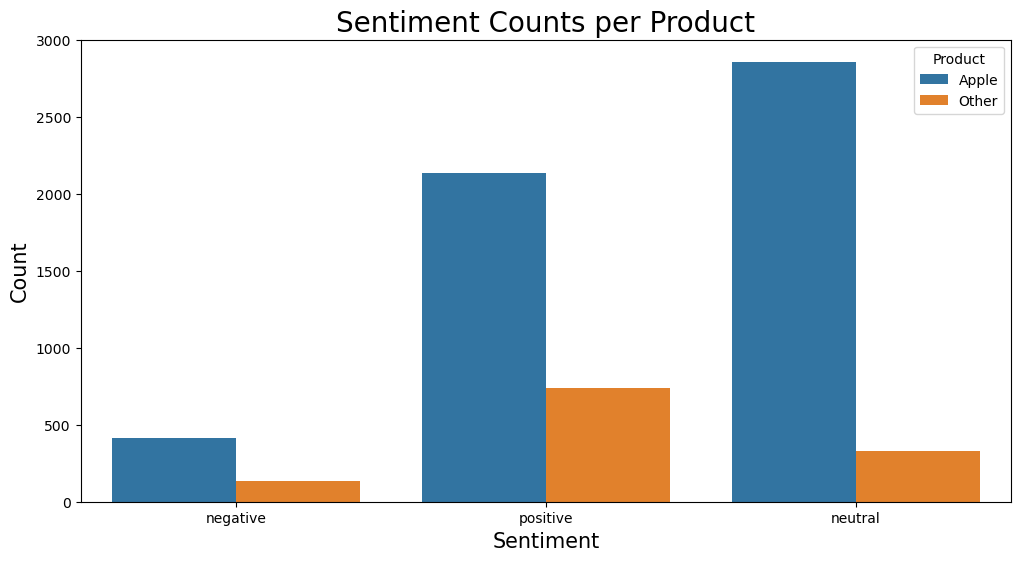

In [34]:
# Plotting the sentiment counts and comparing them against each other
plt.figure(figsize=(12,6))
ax = sns.countplot(data=df, x = 'Emotion', hue='Product')
plt.title('Sentiment Counts per Product', size=20)
plt.xlabel('Sentiment', size=15)
plt.ylabel('Count', size=15)
plt.show()

From our visualisation, there is a class imbalance but it will be addressed later.

# Text Preprocessing
In this section, we will:
1.Fix contracted words
2.Remove URLs
3.Remove punctuation
4.Convert all text to lowercase
5.Remove stopwords
6.Apply stemming and lemmatization


In [38]:
#initialize the stopword
stop_words = set(stopwords.words('english'))
#Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()
#Create a function that will be called to clean the texts
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove Twitter usernames, hashtags, punctuation, and digits
    text = re.sub(r'@\w+|#|[^\w\s]|[\d]+', '', text)
    
    # Reduce repeated characters (e.g., "loooove" -> "love")
    text = re.sub(r'(.)\1+', r'\1\1', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords and apply lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    # Join the tokens back into a single string
    text = ' '.join(tokens)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text
# Apply the preprocess_text function to the 'Text' column
df_copy['Cleaned_Text'] = df_copy['Text'].apply(preprocess_text)

# Display the cleaned texts
print(df_copy[['Text', 'Cleaned_Text']].head(7))

LookupError: 
**********************************************************************
  Resource [93mwordnet[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('wordnet')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/wordnet[0m

  Searched in:
    - 'C:\\Users\\Admin/nltk_data'
    - 'c:\\Users\\Admin\\anaconda3\\nltk_data'
    - 'c:\\Users\\Admin\\anaconda3\\share\\nltk_data'
    - 'c:\\Users\\Admin\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\Admin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************
